# Specific Test VI. SSL on Real Dataset

## Import Libraries

In [1]:
import os
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
from torchvision import transforms

from tqdm import tqdm

from torchvision.transforms.functional import to_tensor


## Data Preprocessing

Loading Data into List

In [2]:
data_dir = 'real_hst/'
lenses = []
non_lenses = []
for filename in os.listdir(data_dir):
    if filename.endswith(".npy"):
        file_path = os.path.join(data_dir, filename)
        if filename.startswith("nl_"):
            # Data for label 1 (files starting with "nl_")
            data = np.load(file_path)
            non_lenses.append(data)
        else:
            # Data for label 2 (files not starting with "nl_")
            data = np.load(file_path)
            lenses.append(data)

print('Data points for lenses', len(lenses))
print('Data points for non lenses', len(non_lenses))
print('max value with nan values for lenses', np.max(lenses))
print('min value with nan values for non lenses', np.min(non_lenses))

Data points for lenses 152
Data points for non lenses 63
max value with nan values for lenses nan
min value with nan values for non lenses nan


NaN values are present within your list, the solution is to replace them with the average value derived from the non-NaN elements in the list.

In [3]:
avg_lenses = np.nanmean(lenses)
avg_non_lenses = np.nanmean(non_lenses)

lenses = [np.where(np.isnan(arr), avg_lenses, arr) for arr in lenses]
non_lenses = [np.where(np.isnan(arr), avg_non_lenses, arr) for arr in non_lenses]

max_value_lenses = np.max(lenses)
min_value_lenses = np.min(lenses)

max_value_non_lenses = np.max(non_lenses)
min_value_non_lenses = np.min(non_lenses)

print('Max value for lenses', np.max(lenses))
print('max value for non lenses', np.max(non_lenses))

Max value for lenses 204.44829
max value for non lenses 152.85097


Normalising data

In [4]:
norm_lenses = [(arr - min_value_lenses) / (max_value_lenses - min_value_lenses) for arr in lenses]
norm_non_lenses = [(arr - min_value_non_lenses) / (max_value_non_lenses - min_value_non_lenses) for arr in non_lenses]

print('Max value for normalise lenses', np.max(norm_lenses))
print('max value for normalise non lenses', np.max(norm_non_lenses))

Max value for normalise lenses 1.0
max value for normalise non lenses 1.0


In [5]:
class DeepLenseDataset(torch.utils.data.Dataset):
    def __init__(self, data1, data2, transform=None):
        self.data1 = data1
        self.data2 = data2
        self.transform = transform
        
    def __len__(self):
        return len(self.data1) + len(self.data2)

    def __getitem__(self, index):
        if index < len(self.data1):
            img    = self.data1[index]
            target = torch.tensor(0)
        else:
            img    = self.data2[index - len(self.data1)]
            target =  torch.tensor(1)
        #print(img)

        #img = Image.fromarray(img)

        img = to_tensor(img)

        img = img.repeat(3,1,1)
        #print(img)
        if self.transform is not None:
            img = self.transform(img)
            img = self.transform(img)
            
        

        return img, img, target

## Model

MoCo : Momentum Contrast for unsupervised visual representation learning

In [6]:
from torchvision.models import resnet50
class MoCo(nn.Module):
    def __init__(self, dim=128, K=128, m=0.999, T=0.07): # Parameters from original paper
        super().__init__()
        self.K = K
        self.m = m
        self.T = T
        self.encoder_q = resnet50(num_classes=dim)
        self.encoder_k = resnet50(num_classes=dim)

        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data.copy_(param_q.data)
            # Make sure key encoder parameters are not effected by gradients
            param_k.requires_grad = False

        self.register_buffer("queue", torch.randn(dim, K))
        self.queue = nn.functional.normalize(self.queue, dim=0)
        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))

    @torch.no_grad()
    def _momentum_update_key_encoder(self): # momentum for weights of encoders
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data = param_k.data * self.m + param_q.data *(1. - self.m)

    @torch.no_grad()
    def _dequeue_and_enqueue(self, keys):
        batch_size = keys.shape[0]
        ptr = int(self.queue_ptr)
        assert self.K % batch_size == 0
        self.queue[:, ptr:ptr + batch_size] = keys.T
        ptr = (ptr + batch_size) % self.K
        self.queue_ptr[0] = ptr


    def forward(self, im_q, im_k):
        q = self.encoder_q(im_q)
        q = nn.functional.normalize(q, dim=1)
        with torch.no_grad():
            self._momentum_update_key_encoder()
            k = self.encoder_k(im_k)
            k = nn.functional.normalize(k, dim=1)
        # compute dot product
        l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1)
        l_neg = torch.einsum('nc,ck->nk', [q, self.queue.clone().detach()])
        logits = torch.cat([l_pos, l_neg], dim=1)
        logits /= self.T # do temperature annelling like the original paper
        labels = torch.zeros(logits.shape[0], dtype=torch.long)#.cuda()
        self._dequeue_and_enqueue(k)
        return logits, labels


## Training 

In [7]:
batch_size = 128
epochs = 10
#device = torch.device('cuda:0' if torch.cuda.is_available else "cpu")
device = "cpu"
# augumentation = [
#     transforms.RandomResizedCrop(224, scale=(0.2, 1.)),
#     transforms.RandomGrayscale(p=0.2),
#     transforms.ColorJitter(0.4, 0.4, 0.4, 0.4),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor()
#   ]
augumentation = None
dataset = DeepLenseDataset(norm_lenses, norm_non_lenses, transform=augumentation)
dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, drop_last=True)
model = MoCo().to(device)
criterion = nn.CrossEntropyLoss()#.to(device)
optimizer = torch.optim.SGD(model.parameters(), 0.03, momentum=0.9, weight_decay=1e-4)
for epoch in range(epochs):
    pbar = tqdm(dataloader)
    for i, (images_q, images_k, _) in enumerate(dataloader):
        
        im_q=images_q.to(device)
        im_k=images_k.to(device)
        output, target = model(im_q, im_k)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

torch.save(model.state_dict(), "moco.pth")

  0%|          | 0/1 [00:54<?, ?it/s]


## Classification using SSL model

In [11]:
model_path = "moco.pth"
model1 = MoCo().to(device)
model1.load_state_dict(torch.load(model_path))
classifier = model1.encoder_q
classifier.fc = nn.Linear(2048, 2, bias=True).to(device)
#loader = get_loader(aug, per)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(classifier.fc.parameters(), 0.008)
l = []
for epochs in tqdm(range(5)):
    for images, _, _ in dataloader:
        optimizer.zero_grad()
        output = classifier(images.to(device))
        loss = criterion(output, target)
        loss.backward()
        l.append(loss.item())
        optimizer.step()

100%|██████████| 5/5 [03:14<00:00, 38.89s/it]


## Evaluation

/home/rishi/ls/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


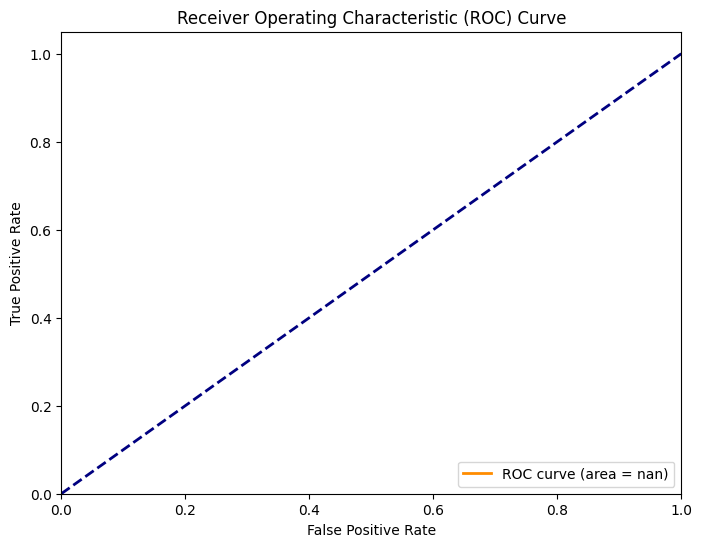

In [18]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

import matplotlib.pyplot as plt

all_labels = []
all_scores = []

# Set the model to evaluation mode
classifier.eval()

# Iterate over the validation set
with torch.no_grad():
    for val_inputs, _, val_labels in dataloader:
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        val_outputs = classifier(val_inputs)
        
        # Assuming the model outputs raw logits, apply softmax to get probabilities
        probabilities = torch.nn.functional.softmax(val_outputs, dim=1)
        
        all_labels.extend(val_labels.cpu().numpy())
        all_scores.extend(probabilities.cpu().numpy())

# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_scores = np.array(all_scores)

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(all_labels, all_scores[:, 1])
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()